In [1]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pcntoolkit.util.output
from pcntoolkit import BLR, BsplineBasisFunction, CompositeBasisFunction, NormativeModel, NormData, plot_centiles_advanced

sns.set_style("darkgrid")

# Suppress some annoying warnings and logs
pymc_logger = logging.getLogger("pymc")

pymc_logger.setLevel(logging.WARNING)
pymc_logger.propagate = False

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pcntoolkit.util.output.Output.set_show_messages(False)


In [2]:
save_path = os.path.join("pcntoolkit_resources", "data")
os.makedirs(save_path, exist_ok=True)
data_path = os.path.join(save_path, "fcon1000.csv")
if not os.path.exists(data_path):
    data = pd.read_csv(
        "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
    )
    data.to_csv(data_path, index=False)
else:
    data = pd.read_csv(data_path)

# Define the variables
sex_map = {0: "F", 1: "M"}
data["sex"] = data["sex"].map(sex_map)
subject_ids = "sub_id"
covariates = ["age", "EstimatedTotalIntraCranialVol"]
batch_effects = ["sex", "site"]
response_vars = ["WM-hypointensities", "Right-Lateral-Ventricle", "Right-Amygdala", "CortexVol"]

data = NormData.from_dataframe("fcon1000", data, covariates, batch_effects, response_vars)
train, test = data.train_test_split()

In [3]:
template_blr = BLR(
    name="template",
    basis_function_mean=CompositeBasisFunction(
        (BsplineBasisFunction(basis_column=0, degree=3, nknots=5), BsplineBasisFunction(basis_column=1, degree=3, nknots=5))
    ),
    # We use a B-spline basis expansion for the mean, so the predicted mean is a smooth function of the covariates
    fixed_effect=True,  # By setting fixed_effect=True, we \model offsets in the mean for each individual batch effect,
    fixed_effect_slope=True,  # We also model a fixed effect in the slope of the mean for each individual batch effect
    fixed_effect_var_slope=True,
    heteroskedastic=True,  # We want the variance to be a function of the covariates too
    warp_name="warpsinharcsinh",  # We configure a sinh-arcsinh warp, so we can model flexible non-gaussian distributions
)

In [4]:
model = NormativeModel(
    # The regression model to use for the normative model.
    template_regression_model=template_blr,
    # Whether to save the model after fitting.
    savemodel=True,
    # Whether to evaluate the model after fitting.
    evaluate_model=True,
    # Whether to save the results after evaluation.
    saveresults=True,
    # Whether to save the plots after fitting.
    saveplots=True,
    # The directory to save the model, results, and plots.
    save_dir="resources/composite_basis/save_dir",
    # The scaler to use for the input data. Can be either one of "standardize", "minmax", "robminmax", "none"
    inscaler="standardize",
    # The scaler to use for the output data. Can be either one of "standardize", "minmax", "robminmax", "none"
    outscaler="standardize",
)

In [5]:
model.fit_predict(train, test)

/opt/anaconda3/envs/test/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.26056e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/pcntoolkit/util/output.py:239: UserWarning: Process: 58512 - 2025-12-10 12:14:17 - Estimation of posterior distribution failed due to: 
Matrix is not positive definite
  warnings.warn(message)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.62586e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.51245e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/test/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcon

<xarray.NormData> Size: 100kB
Dimensions:            (observations: 216, response_vars: 4, covariates: 2,
                        batch_effect_dims: 2, centile: 5, statistic: 11)
Coordinates:
  * observations       (observations) int64 2kB 756 769 692 616 ... 751 470 1043
  * response_vars      (response_vars) <U23 368B 'WM-hypointensities' ... 'Co...
  * covariates         (covariates) <U29 232B 'age' 'EstimatedTotalIntraCrani...
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * centile            (centile) float64 40B 0.05 0.25 0.5 0.75 0.95
  * statistic          (statistic) <U8 352B 'EXPV' 'MACE' ... 'SMSE' 'ShapiroW'
Data variables:
    subject_ids        (observations) int64 2kB 756 769 692 616 ... 751 470 1043
    Y                  (observations, response_vars) float64 7kB 2.721e+03 .....
    X                  (observations, covariates) float64 3kB 63.0 ... 1.603e+06
    batch_effects      (observations, batch_effect_dims) <U17 29kB 'F' ... 'Q...
    Z                  (observations, response_vars) float64 7kB 1.029 ... -0...
    centiles           (centile, observations, response_vars) float64 35kB 52...
    logp               (observations, response_vars) float64 7kB -1.886 ... -0.5
    Yhat               (observations, response_vars) float64 7kB 1.865e+03 .....
    statistics         (response_vars, statistic) float64 352B 0.3219 ... 0.9908
Attributes:
    real_ids:                       False
    is_scaled:                      False
    name:                           fcon1000_test
    unique_batch_effects:           {np.str_('sex'): [np.str_('F'), np.str_('...
    batch_effect_counts:            defaultdict(<function NormData.register_b...
    covariate_ranges:               {np.str_('age'): {'mean': np.float64(28.2...
    batch_effect_covariate_ranges:  {np.str_('sex'): {np.str_('F'): {np.str_(...

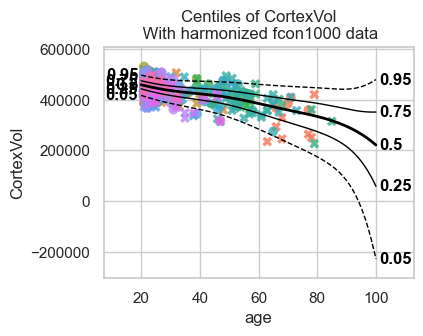

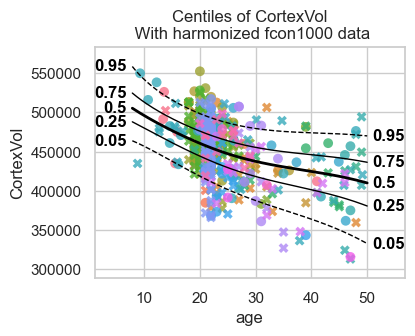

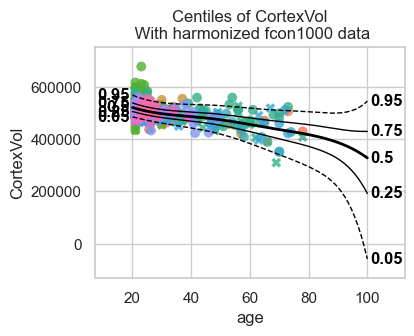

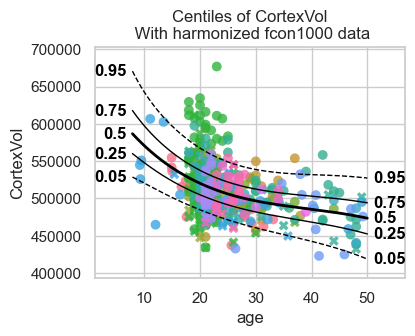

In [6]:
plot_centiles_advanced(
    model,
    covariate="age",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [20, 100], "EstimatedTotalIntraCranialVol": [0.75e6, 1.5e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)
plot_centiles_advanced(
    model,
    covariate="age",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [0, 50], "EstimatedTotalIntraCranialVol": [0.75e6, 1.5e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)
plot_centiles_advanced(
    model,
    covariate="age",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [20, 100], "EstimatedTotalIntraCranialVol": [1.5e6, 2.0e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)
plot_centiles_advanced(
    model,
    covariate="age",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [0, 50], "EstimatedTotalIntraCranialVol": [1.5e6, 2.0e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)


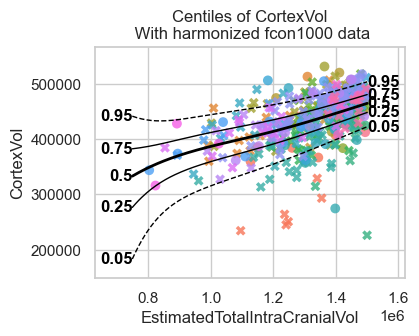

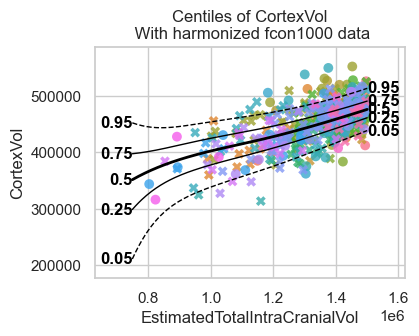

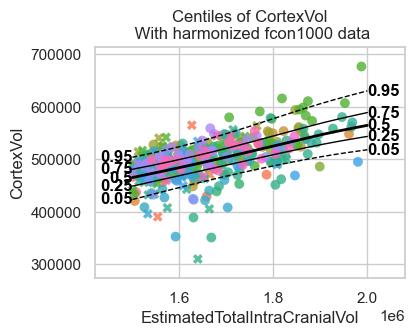

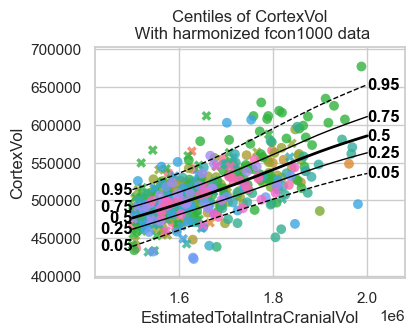

In [7]:
plot_centiles_advanced(
    model,
    covariate="EstimatedTotalIntraCranialVol",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [20, 100], "EstimatedTotalIntraCranialVol": [0.75e6, 1.5e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)
plot_centiles_advanced(
    model,
    covariate="EstimatedTotalIntraCranialVol",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [0, 50], "EstimatedTotalIntraCranialVol": [0.75e6, 1.5e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)
plot_centiles_advanced(
    model,
    covariate="EstimatedTotalIntraCranialVol",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [20, 100], "EstimatedTotalIntraCranialVol": [1.5e6, 2.0e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)
plot_centiles_advanced(
    model,
    covariate="EstimatedTotalIntraCranialVol",
    response_vars=["CortexVol"],
    scatter_data=data,
    covariate_ranges={"age": [0, 50], "EstimatedTotalIntraCranialVol": [1.5e6, 2.0e6]},
    batch_effects="all",
    show_legend=False,
    plt_kwargs={"figsize": (4, 3)},
)